# ERT inversion - beyond the standard

Here, we exemplify the possibilities of pyGIMLi by treating an ERT timelapse data set. Most of the strategies are independent on the method and can be used for other types of data.

The data set here was published by Hübner et al. (2017) and describes a shallow infiltration experiment using a surface electrode layout.


In [1]:
# We import some basic libraries like numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Furthermore we import pygimli and two of its modules
import pygimli as pg
from pygimli.physics import ert
import pygimli.meshtools as mt
from pygimli.viewer import pv

From the whole timelapse set of data files we load a single one, show its properties.

In [3]:
data = ert.load("020.dat")
print(data)

Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


The data contains 2849 data using 392 electrodes. In the data container, there are the A-B-M-N numbers of the electrodes and resistances (`'r'`). We first plot the electrode positions (Hübner et al. 2017, Fig. 1).

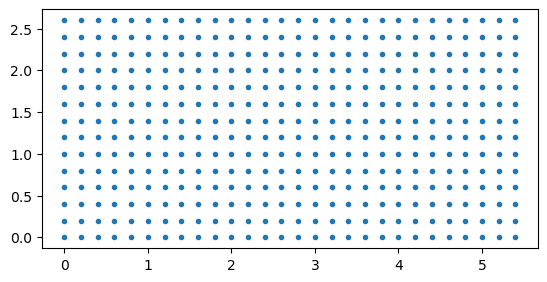

In [4]:
plt.plot(pg.x(data), pg.y(data), ".")
plt.gca().set_aspect(1.0);

We first compute geometric factors and apparent resistivities and store both in the data container.

In [5]:
data["k"] = ert.geometricFactors(data)
data["rhoa"] = data["r"] * data["k"]

The data exhibit mostly dipole-dipole data measured with a 12-channel ABEM Terrameter LS2 instrument. To fill up the channels, some multi-gradient and some square arrays have been added. We can have a look at the data by using `data.show()` (`ert.show(data)`). 

17/03/24 - 19:47:23 - pyGIMLi - INFO - found 245 x values
17/03/24 - 19:47:23 - pyGIMLi - INFO - found 143 y values
17/03/24 - 19:47:23 - pyGIMLi - INFO - x vector length: 2849
17/03/24 - 19:47:23 - pyGIMLi - INFO - y vector length: 2849
17/03/24 - 19:47:23 - pyGIMLi - INFO - v vector length: 2849
17/03/24 - 19:47:23 - pyGIMLi - INFO - 1390 data of 2849 not shown


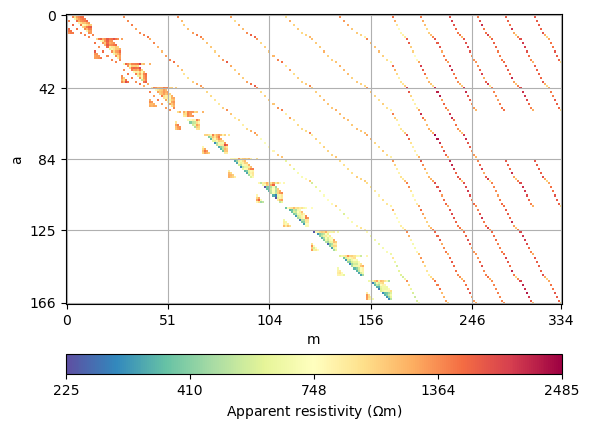

In [6]:
data.show(style="A-M");

We can already see the pseudosections on the main diagonal with some reciprocals mirrored at the diagonal, plus some measurements between the lines (off-diagonals).

In [7]:
# check reciprocals
iFwd, iBwd = ert.reciprocalIndices(data)
print(len(iFwd), len(iBwd))

1943 1943


We have a very limited amount of reciprocal data pairs with which we can do a reciprocal analysis.

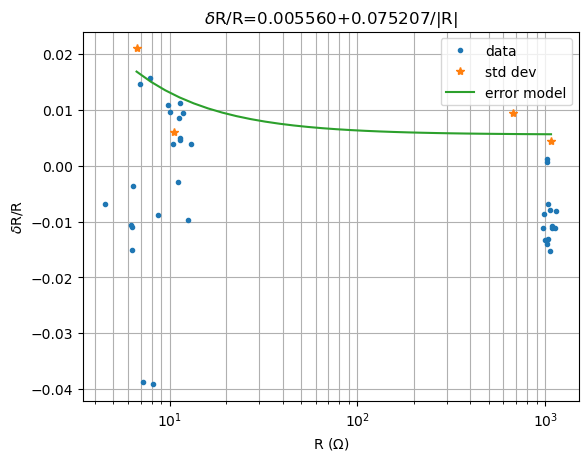

In [8]:
ert.fitReciprocalErrorModel(data, show=True, rel=True);

The number is not large enough and the distribution of R bimodal (DD vs. MG array). For an example with more rigorous data and background of normal-reciprocal analysis see, based on Udphuay et al. (2011) paper,
https://www.pygimli.org/_examples_auto/3_ert/plot_10_reciprocal_analysis.html 

In order to account for other error sources like electrode positions,
we add 1% and estimate a data error using 2% and 70mOhm (no influence).

In [9]:
data.estimateError(relativeError=0.02, absoluteError=0.07)
print(min(data["err"]), max(data["err"]))
# data.show("err", style="A-M")

0.020027533256240217 0.02046348407601139


We extract a single profile from the data.

Data: Sensors: 14 data: 71, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid']
Detecting small distances, using mm accuracy


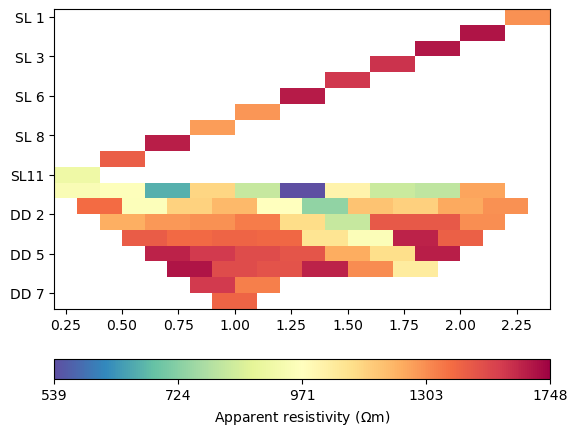

In [10]:
x0 = data.subset(x=0)
print(x0)
x0.setSensors(np.column_stack([pg.y(x0), pg.x(x0)])) # auto for x/y
ax, cb = x0.show()

The upper part is a single multi-gradient using the outermost electrodes, the lower a dipole-dipole section. If we think one of the values is an outlier, we can remove it by logical operations.

Detecting small distances, using mm accuracy


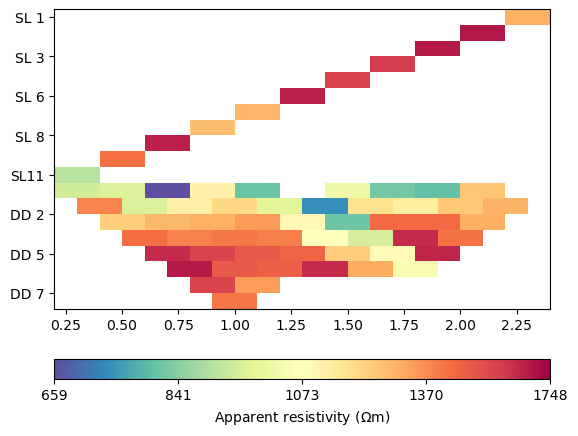

In [11]:
x0.remove(x0["rhoa"] < 600)
ax, cb = x0.show()

In [12]:
mgr = ert.Manager(x0)
mgr.invert(verbose=True)

17/03/24 - 19:47:35 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 19:47:35 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 19:47:35 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 19:47:35 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 19:47:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/03/24 - 19:47:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/03/24 - 19:47:35 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
17/03/24 - 19:47:35 - pyGIMLi - INFO - Use median(data values)=1340.4949999999994
17/03/24 - 19:47:35 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=1340.495000/1340.495000
17/03/24 - 19:47:35 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002B5AD851950>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002B5AD849040>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002B5AD851C70>
min/max (data): 659/1748
min/max (error): 2%/2.01%
min/max (start model): 1340/1340
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  135.77
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   17.23 (dPhi = 85.90%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.71 (dPhi = 74.48%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.65 (dPhi = 1.79%) lam: 20.0
################################################################################
#                Abort criterion reached: dPhi = 1.79 (< 2.0%)         

186 [859.317904049626,...,1921.6290695086232]

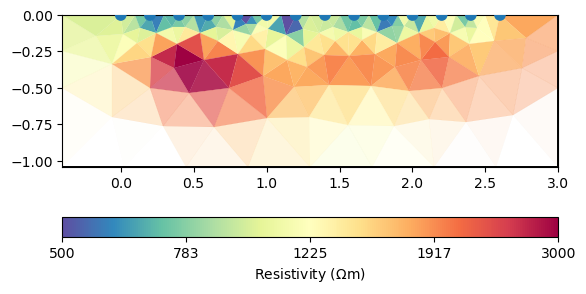

In [15]:
# We show the result using a predefined color-scale
kw = dict(cMin=500, cMax=3000, cMap="Spectral_r", logScale=True)#,
        #   xlabel="x (m)", ylabel="z (m)")
ax, cb = mgr.showResult(**kw)
# we can further modify the figure using the axis and colorbar handles

We save the result for later visualization. The inversion mesh can be populated with arbitrary keywords by arrays.

In [16]:
x0result = mgr.paraDomain
x0result["res"] = mgr.model

We now choose another profile along the y axis.

Data: Sensors: 14 data: 139, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid', 'ya', 'yb', 'ym', 'yn']
Detecting small distances, using mm accuracy


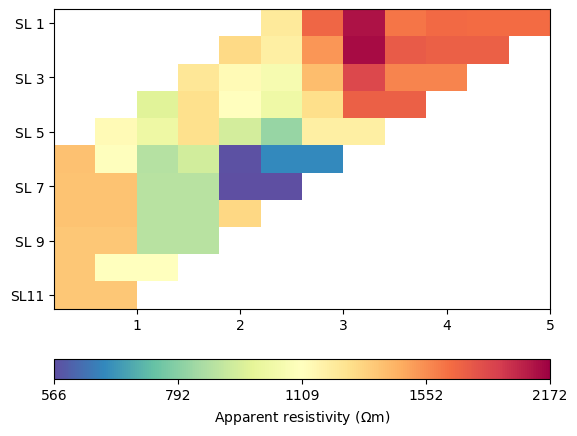

In [17]:
y1 = data.subset(y=0.6)
y1.setSensors(y1.sensors() * np.array([1, 0, 0]))  # auto
print(y1)
y1.show();

17/03/24 - 19:48:11 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 19:48:11 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 19:48:11 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 19:48:11 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 19:48:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/03/24 - 19:48:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/03/24 - 19:48:11 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
17/03/24 - 19:48:11 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
17/03/24 - 19:48:11 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=1227.930000/1227.930000
17/03/24 - 19:48:11 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002B5ACD3E630>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002B5ACD3E270>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002B5AD5CF460>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  194.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   10.23 (dPhi = 94.59%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.69 (dPhi = 89.26%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.69)                   #
################################################################################


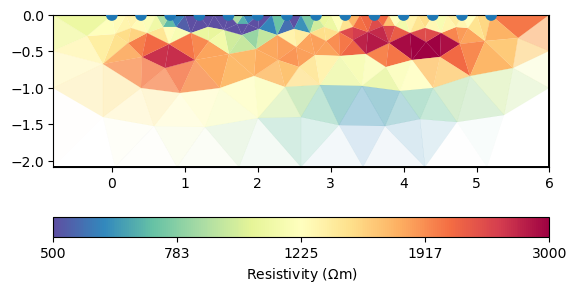

In [18]:
mgr = ert.Manager(y1)
mgr.invert(zWeight=0.3, verbose=True)
ax, cb = mgr.showResult(**kw)

## Mesh generation and regularization
We now want to improve the mesh a bit, step by step, introducing
a smaller boundary, a smaller surface discretization `paraDX`, a
smaller depth, an improved quality and a maximum cell size.

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2b5ad33db80>)

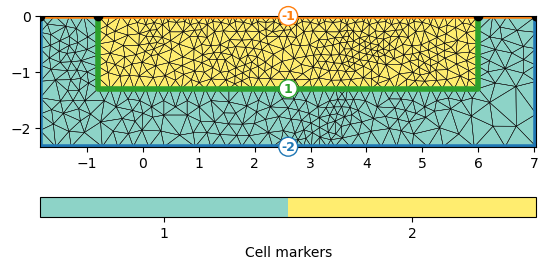

In [19]:
plc = mt.createParaMeshPLC(y1, paraDX=0.25, paraDepth=1.3, 
                           boundary=0.2, paraMaxCellSize=0.03)
mesh = mt.createMesh(plc, quality=34.4)
pg.show(mesh, markers=True, showMesh=True)

17/03/24 - 19:48:40 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 19:48:40 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 19:48:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/03/24 - 19:48:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/03/24 - 19:48:40 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2367 Cells: 4536 Boundaries: 3500
17/03/24 - 19:48:40 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
17/03/24 - 19:48:40 - pyGIMLi - INFO - Created startmodel from forward operator: 699, min/max=1227.930000/1227.930000
17/03/24 - 19:48:40 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002B5ACD3E630>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002B5ACD3E270>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002B5ACE242E0>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  194.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   12.04 (dPhi = 93.30%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.32 (dPhi = 80.96%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.94 (dPhi = 9.72%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2b5ad224280>)

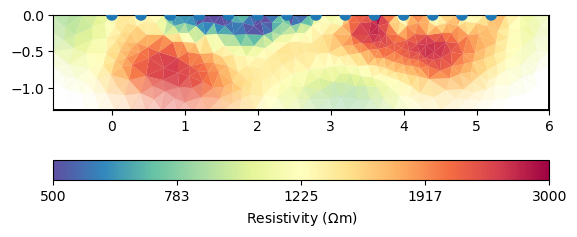

In [20]:
mgr.setMesh(mesh)
mgr.invert(verbose=True)
mgr.showResult(**kw)

The default regularization scheme are smoothness constraints of first-order, i.e. a derivative across the model cells. We can also apply second order constraints by setting this inversion property.

17/03/24 - 19:48:42 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
17/03/24 - 19:48:42 - pyGIMLi - INFO - Created startmodel from forward operator: 699, min/max=1227.930000/1227.930000
17/03/24 - 19:48:42 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002B5ACD3E630>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002B5ACD3E270>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002B5AD12D340>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  194.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   30.78 (dPhi = 84.02%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.57 (dPhi = 93.71%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.77 (dPhi = 38.54%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² 

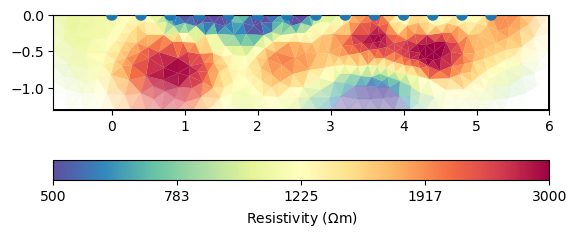

In [21]:
mgr.inv.setRegularization(cType=2)
mgr.invert(verbose=True)
ax, cb = mgr.showResult(**kw)

Alternative to classical smoothness constraints, geostatistic operators can be used for regularization. For details on the method see the tutorial
https://www.pygimli.org/_tutorials_auto/3_inversion/plot_6-geostatConstraints.html

17/03/24 - 19:50:04 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
17/03/24 - 19:50:04 - pyGIMLi - INFO - Created startmodel from forward operator: 699, min/max=1227.930000/1227.930000
17/03/24 - 19:50:04 - pyGIMLi - INFO - Starting inversion.
17/03/24 - 19:50:04 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 2 with: I=[1, 0.1], dip=0, strike=0
17/03/24 - 19:50:04 - pyGIMLi - INFO - Cache c:\Guenther.T\src\gimli\gimli\pygimli\math\matrix.py:createCm05 restored (0.3s x 2): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\6780675307155642634


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002B5ACD3E630>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002B5ACD3E270>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002B5AD4B4C40>
min/max (data): 566/2172
min/max (error): 2%/2.01%
min/max (start model): 1228/1228
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  194.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   42.06 (dPhi = 78.10%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.53 (dPhi = 85.53%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.69 (dPhi = 43.85%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    0.99 (dPhi = 45.20%) lam: 

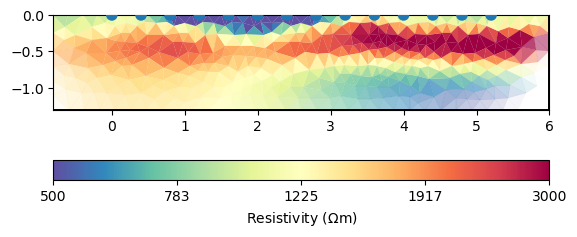

In [22]:
mgr.inv.setRegularization(correlationLengths=[1, 0.1])
mgr.invert(verbose=True)
ax, cb = mgr.showResult(**kw)

For a more extensive comparison of regularization methods, see the tutorial https://www.pygimli.org/_tutorials_auto/3_inversion/plot_5_Regularization.html

Other options to discuss or link
* lam
* limits
* 

## Additional information
### Structural constraints
Imagine we have knowledge on a geological interface, e.g. from seismic or GPR reflections. To include this structural information into the inversion, we create a line with a marker>0 and re-create the mesh. 

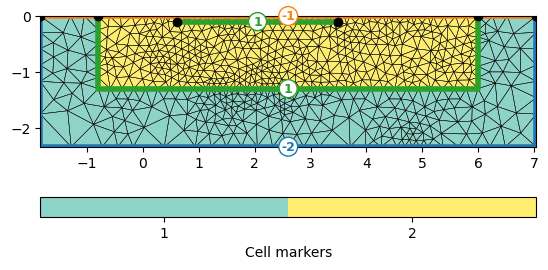

In [27]:
line = mt.createLine(start=[0.6, -0.1], end=[3.5, -0.1], marker=1)
# pg.show(plc+line)
mesh = mt.createMesh(plc+line, quality=34.4)
ax, cb = pg.show(mesh, markers=True, showMesh=True)

The interface is built into the mesh and deactivates smoothness constraints across it in inversion. For a more rigorous example see
https://www.pygimli.org/_examples_auto/6_inversion/plot_4_structural_constraints.html

We create a new manager, set the created mesh and run inversion.

17/03/24 - 19:54:54 - pyGIMLi - INFO - Found 2 regions.
17/03/24 - 19:54:54 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/03/24 - 19:54:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/03/24 - 19:54:54 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/03/24 - 19:54:54 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2668 Cells: 5140 Boundaries: 3952
17/03/24 - 19:54:54 - pyGIMLi - INFO - Use median(data values)=1227.9300000000012
17/03/24 - 19:54:54 - pyGIMLi - INFO - Created startmodel from forward operator: 827, min/max=1227.930000/1227.930000


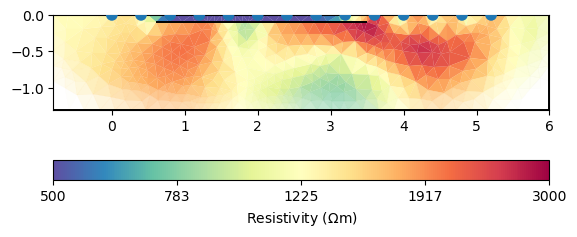

In [28]:
mgr = ert.Manager(y1)  # only setMesh fails!!
mgr.setMesh(mesh)
mgr.invert()
ax, cb = mgr.showResult(**kw)

As a result, there is a sharp contrast in the area of the infiltration, whereas outside the effect of the constraint is lower. 

### Region-specific inversion
The regularization does not have to be the same for the whole modelling domain. We create a cube under the infiltration area for which we use different settings.

In [30]:
print("TODO")

TODO


For a more thorough overview on the region options see the tutorial
https://www.pygimli.org/_tutorials_auto/3_inversion/plot_8-regionWise.html

### Parameter constraints
Besides from structural information, one may have parameter information, e.g. from a borehole or direct-push sounding. For an example, see
https://www.pygimli.org/_examples_auto/6_inversion/plot_5_ert_with_priors.html

### Bringing petrophysics into inversion


## 3D visualization
Now we bring the 2D result of the y-directed profile  into 3D by changing the dimension, switching y (in 2D depth axis) and z coordinates and shifting the mesh into the correct y position.

In [ ]:
y1result = mgr.paraDomain
y1result["res"] = mgr.model
y1result.setDimension(3)
y1result.swapCoordinates(1, 2) # make 2D depth to 3D depth
y1result.translate([0, 0.6, 0])

Similarly, we do so for the y-directed profile x0, for which we additionally have to exchange the x with the y coordinate

In [ ]:
x0result.setDimension(3)
x0result.swapCoordinates(1, 2) # make 2D depth to 3D depth
x0result.swapCoordinates(0, 1) # make 2D x to 3D y

In [ ]:
pl, _ = pg.show(x0result, "res", **kw, hold=True)
pv.drawMesh(pl, y1result, label="res", **kw)
pl.show()

## 3D inversion
For a 3D inversion of all data, one needs to create a 3D mesh. To do so, first the geometry is created and then meshes (just like in 2D).

In [ ]:
plc = mt.createParaMeshPLC3D(data)
mesh = mt.createMesh(plc, quality=1.3)
print(mesh)
pg.show(mesh, style="wireframe")

In [ ]:
mgr3d = ert.Manager(data)
mgr3d.setMesh(mesh)
mgr3d.invert(verbose=True)

In [ ]:
result3d = mgr3d.paraDomain
result3d["res"] = mgr3d.paraModel()
# pg.show(result3d, "res", **kw);
pl, _ = pg.show(result3d, label="res", style="surface", hold=True, **kw,
                filter={"threshold": dict(value=500, scalars="res", method="lower")})
pv.drawMesh(pl, result3d, label="res", style="surface", **kw,
            filter={"slice": dict(normal="y", origin=[0, 1, 0])})
pl.show()

## Timelapse inversion

For this data set, we have a lot of data over a couple of days.
Of course, we could invert these step by step and compare the
individual models (SHOULD WE DO THAT HERE?).
For timelapse ERT, there is a specialized class `TimelapseERT`.
It handles the data, e.g. filtering and masking, but also 
exhibits several timelapse strategies, such as 4D inversion.

For more details, see the example on
https://www.pygimli.org/_examples_auto/3_ert/plot_09_ert_timelapse.html

In [ ]:
tl = ert.TimelapseERT("*.dat")
print(tl)

In [ ]:
tl.fitReciprocalErrorModel(rel=False, show=True)

In [ ]:
# tl.fullInversion()

## References
* Hübner, R., Günther, T., Heller, K., Noell, U. & Kleber, A. (2017): Impacts of a capillary barrier on infiltration and subsurface stormflow in layered slope deposits monitored with 3-D ERT and hydrometric measurements. Hydrol. Earth Syst. Sci. 21, 5181-5199, doi:10.5194/hess-21-5181-2017.
